<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import accuracy_score, r2_score

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing (real).csv')

In [3]:
house1 = house.copy()

In [4]:
# A:
house1.sample(20)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1048,1049,20,RL,100.0,21750,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,11,2009,WD,Normal,115000
1230,1231,90,RL,NaN,18890,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,8300,8,2007,WD,Normal,190000
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
1257,1258,30,RL,56.0,4060,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,99900
300,301,190,RL,90.0,15750,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,157000
1196,1197,60,RL,58.0,14054,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2006,New,Partial,219210
977,978,120,FV,35.0,4274,Pave,Pave,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2007,New,Partial,199900
1447,1448,60,RL,80.0,10000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2007,WD,Normal,240000
1409,1410,60,RL,46.0,20544,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,11,2008,WD,Normal,215000
599,600,160,RM,24.0,1950,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,7,2008,COD,Normal,151000


In [5]:
house1.shape

(1460, 81)

In [6]:
house1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [7]:
house1.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQual         81
GarageCond         81
PavedDrive

#### <font color = blue>For columns with NA values and are of int64 type, imputation using mean was carried out for these 3 columns (below).</font>

In [8]:
from sklearn.preprocessing import Imputer
values = house1[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].values
imp = Imputer(missing_values='NaN', strategy='mean', axis = 0)
imp.fit(values)
transformed_values = imp.transform(values)
transformed_values

array([[  65.,  196., 2003.],
       [  80.,    0., 1976.],
       [  68.,  162., 2001.],
       ...,
       [  66.,    0., 1941.],
       [  68.,    0., 1950.],
       [  75.,    0., 1965.]])

In [9]:
house1[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']] = transformed_values
house1['GarageYrBlt'].head()

0    2003.0
1    1976.0
2    2001.0
3    1998.0
4    2000.0
Name: GarageYrBlt, dtype: float64

In [10]:
house1.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### <font color = blue>Categorical columns such as Alley, MasVnrType, PoolQC, Fence and MiscVal are not imputed.</font>

In [11]:
house1.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage         0
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          0
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt         0
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQual         81
GarageCond         81
PavedDrive

In [12]:
house1.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

#### <font color = blue>Only four categories from MSZoning column were chosen. The non-residential ones were dropped.</font>

In [13]:
house1['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [14]:
house1 = house1[(house1['MSZoning'] != 'FV') & (house1['MSZoning'] != 'C (all)')]
house1['MSZoning'].value_counts()

RL    1151
RM     218
RH      16
Name: MSZoning, dtype: int64

#### <font color = blue>Also, outliers were dropped from the column SalePrice. Any houses beyond 700000USD were dropped.</font>

In [15]:
house1['SalePrice'].max()

755000

In [16]:
house1 = house1[(house1['SalePrice'] < 700000)]

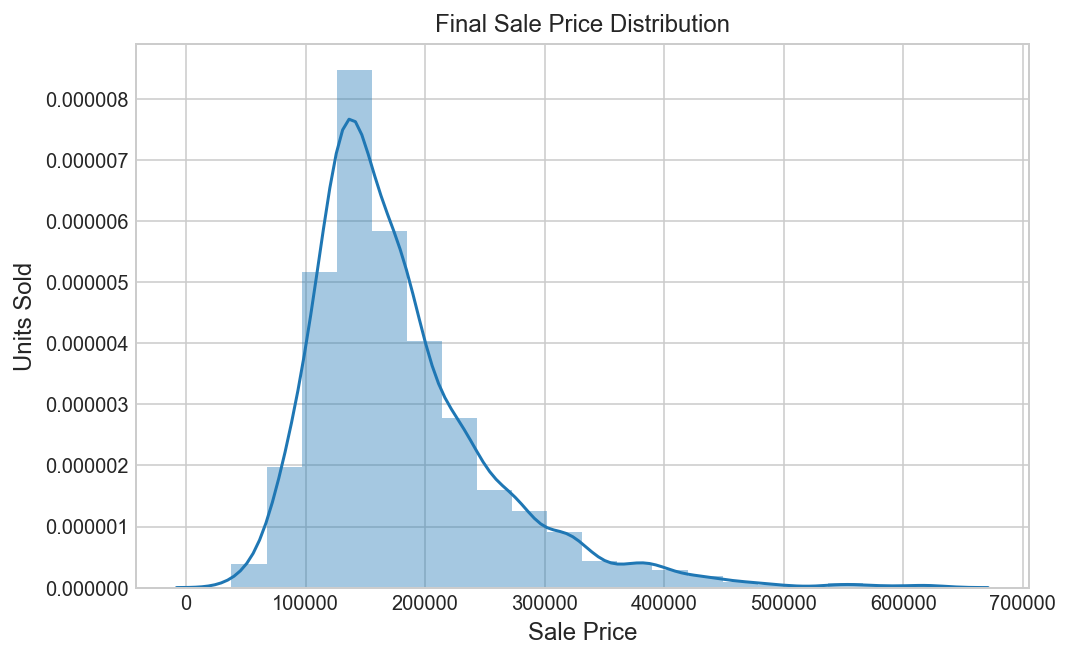

In [17]:
# plotting Sales Price Distribution from 2006 - 2010 (inclusive)
plt.figure (figsize = (8,5))
sns.distplot(house1['SalePrice'], bins = 20)
plt.ylabel('Units Sold', fontsize = 12)
plt.xlabel('Sale Price', fontsize = 12)
plt.title('Final Sale Price Distribution');

In [18]:
house1.shape

(1383, 81)

#### <font color = blue>Feature Selection and Feature Engineering for fixed characteristics.</font>

In [19]:
fixed_char = house1[['Id', 'MSZoning', 'LotArea', 'Street', 'LotShape', 'LandContour',\
                     'LotConfig', 'LandSlope','Neighborhood', 'Condition1', 'Condition2',\
                     'BldgType', 'HouseStyle','YearBuilt', 'YearRemodAdd', 'Foundation', 
                     'BsmtExposure', 'TotalBsmtSF', 'Electrical','GrLivArea',\
                     'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
                     'KitchenAbvGr', 'TotRmsAbvGrd','Functional', 'Fireplaces','GarageType', 
                     'GarageYrBlt','GarageCars', 'GarageArea', 'PavedDrive', 'WoodDeckSF', 
                     'OpenPorchSF', 'EnclosedPorch', '3SsnPorch','ScreenPorch', 'YrSold', 'SaleType',
                     'SaleCondition', 'SalePrice', 'OverallQual', 'Fence', 'MiscFeature', 'Alley']]

In [20]:
fixed_char.head()

,Id,MSZoning,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,3SsnPorch,ScreenPorch,YrSold,SaleType,SaleCondition,SalePrice,OverallQual,Fence,MiscFeature,Alley
0,1,RL,8450,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,...,0,0,2008,WD,Normal,208500,7,NaN,NaN,NaN
1,2,RL,9600,Pave,Reg,Lvl,FR2,Gtl,Veenker,Feedr,...,0,0,2007,WD,Normal,181500,6,NaN,NaN,NaN
2,3,RL,11250,Pave,IR1,Lvl,Inside,Gtl,CollgCr,Norm,...,0,0,2008,WD,Normal,223500,7,NaN,NaN,NaN
3,4,RL,9550,Pave,IR1,Lvl,Corner,Gtl,Crawfor,Norm,...,0,0,2006,WD,Abnorml,140000,7,NaN,NaN,NaN
4,5,RL,14260,Pave,IR1,Lvl,FR2,Gtl,NoRidge,Norm,...,0,0,2008,WD,Normal,250000,8,NaN,NaN,NaN


In [21]:
fixed_char1 = fixed_char.copy()

In [22]:
# Looking at the year a garage is built to when it's being sold and how it affects the saleprice of a house.
fixed_char1['Garage&Sold'] = fixed_char1['YrSold'] - fixed_char1['GarageYrBlt']

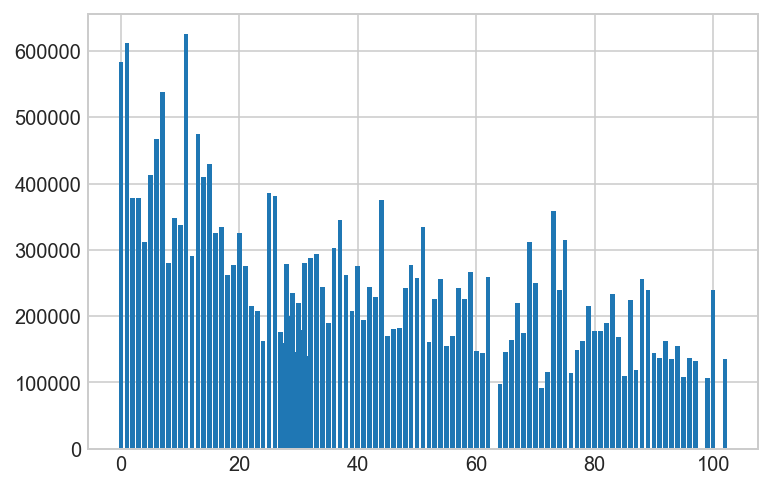

In [23]:
plt.bar(fixed_char1['Garage&Sold'], fixed_char1['SalePrice'])
plt.show()

In [24]:
# Calculating the sq feet of various types of porch a house has into one column.
fixed_char1['TotalPorchSF'] = fixed_char1['OpenPorchSF'] + fixed_char1['EnclosedPorch'] + fixed_char1['3SsnPorch'] \
+ fixed_char1['ScreenPorch']
fixed_char1.head()

,Id,MSZoning,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,YrSold,SaleType,SaleCondition,SalePrice,OverallQual,Fence,MiscFeature,Alley,Garage&Sold,TotalPorchSF
0,1,RL,8450,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,...,2008,WD,Normal,208500,7,NaN,NaN,NaN,5.0,61
1,2,RL,9600,Pave,Reg,Lvl,FR2,Gtl,Veenker,Feedr,...,2007,WD,Normal,181500,6,NaN,NaN,NaN,31.0,0
2,3,RL,11250,Pave,IR1,Lvl,Inside,Gtl,CollgCr,Norm,...,2008,WD,Normal,223500,7,NaN,NaN,NaN,7.0,42
3,4,RL,9550,Pave,IR1,Lvl,Corner,Gtl,Crawfor,Norm,...,2006,WD,Abnorml,140000,7,NaN,NaN,NaN,8.0,307
4,5,RL,14260,Pave,IR1,Lvl,FR2,Gtl,NoRidge,Norm,...,2008,WD,Normal,250000,8,NaN,NaN,NaN,8.0,84


In [25]:
# Having just a column with the total no. of bathrooms 
# (be it full / half / basement or not)
fixed_char1['TotalBaths'] = fixed_char1['BsmtFullBath'] + fixed_char1['BsmtHalfBath']\
+  fixed_char1['FullBath'] + fixed_char1['HalfBath']

fixed_char1.head()

,Id,MSZoning,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,SaleType,SaleCondition,SalePrice,OverallQual,Fence,MiscFeature,Alley,Garage&Sold,TotalPorchSF,TotalBaths
0,1,RL,8450,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,...,WD,Normal,208500,7,NaN,NaN,NaN,5.0,61,4
1,2,RL,9600,Pave,Reg,Lvl,FR2,Gtl,Veenker,Feedr,...,WD,Normal,181500,6,NaN,NaN,NaN,31.0,0,3
2,3,RL,11250,Pave,IR1,Lvl,Inside,Gtl,CollgCr,Norm,...,WD,Normal,223500,7,NaN,NaN,NaN,7.0,42,4
3,4,RL,9550,Pave,IR1,Lvl,Corner,Gtl,Crawfor,Norm,...,WD,Abnorml,140000,7,NaN,NaN,NaN,8.0,307,2
4,5,RL,14260,Pave,IR1,Lvl,FR2,Gtl,NoRidge,Norm,...,WD,Normal,250000,8,NaN,NaN,NaN,8.0,84,4


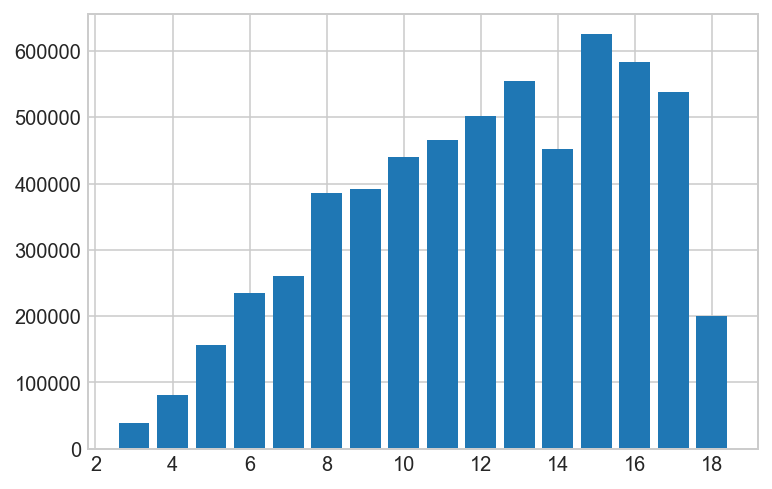

In [26]:
# Creating a column with the total no. of rooms in a house - Total no. of rooms AND bathrooms
fixed_char1['TotalRms'] = fixed_char1['TotalBaths'] + fixed_char1['TotRmsAbvGrd']
plt.bar(fixed_char1['TotalRms'], fixed_char1['SalePrice'])
plt.show()

In [27]:
# The duration that a house has undergone remodelling from the year it was built 
# and how it affects saleprice. It ranges from 0 (newly built) to 123 years old.
fixed_char1['RemodelDur'] = fixed_char1['YearRemodAdd'] - fixed_char1['YearBuilt']
fixed_char1[(fixed_char1['RemodelDur'] == fixed_char1['RemodelDur'].max())]

,Id,MSZoning,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,SalePrice,OverallQual,Fence,MiscFeature,Alley,Garage&Sold,TotalPorchSF,TotalBaths,TotalRms,RemodelDur
747,748,RM,11700,Pave,IR1,Lvl,Corner,Gtl,OldTown,Norm,...,265979,7,NaN,NaN,Pave,59.0,386,2,10,123


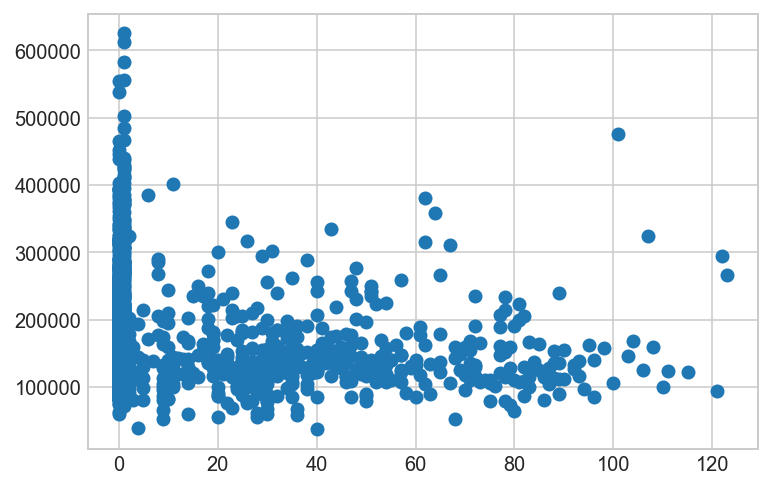

In [28]:
plt.scatter(fixed_char1['RemodelDur'], fixed_char1['SalePrice'])
plt.show()

In [29]:
# This column calculate the diff in year from when a house was remodelled to when 
# it actually got sold and how this affects saleprice. 
fixed_char1['SoldDur'] = fixed_char1['YrSold'] - fixed_char1['YearRemodAdd']
# fixed_char1[(fixed_char1['SoldDur'] == fixed_char1['SoldDur'].max())]

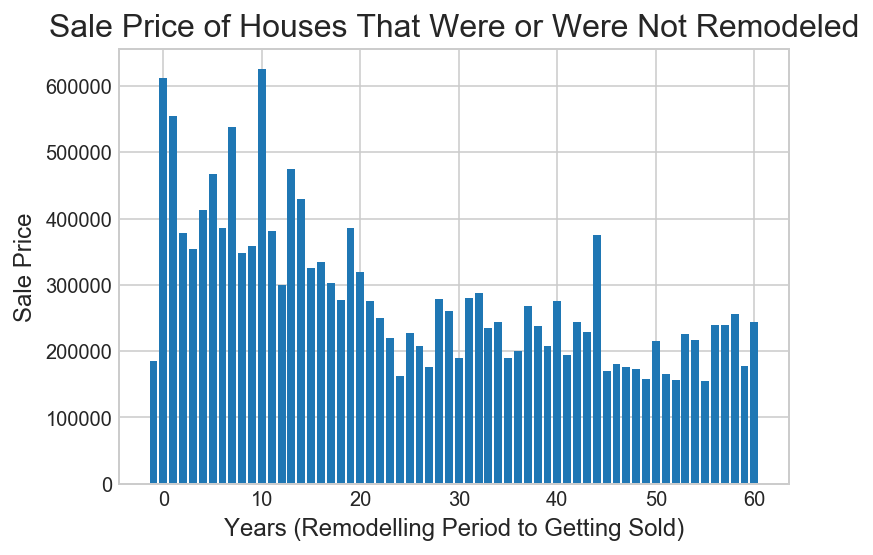

In [30]:
plt.bar(fixed_char1['SoldDur'], fixed_char1['SalePrice'])
plt.ylabel('Sale Price', fontsize = 12)
plt.xlabel('Years (Remodelling Period to Getting Sold)', fontsize = 12)
plt.title('Sale Price of Houses That Were or Were Not Remodeled', fontsize = 16)
plt.show()

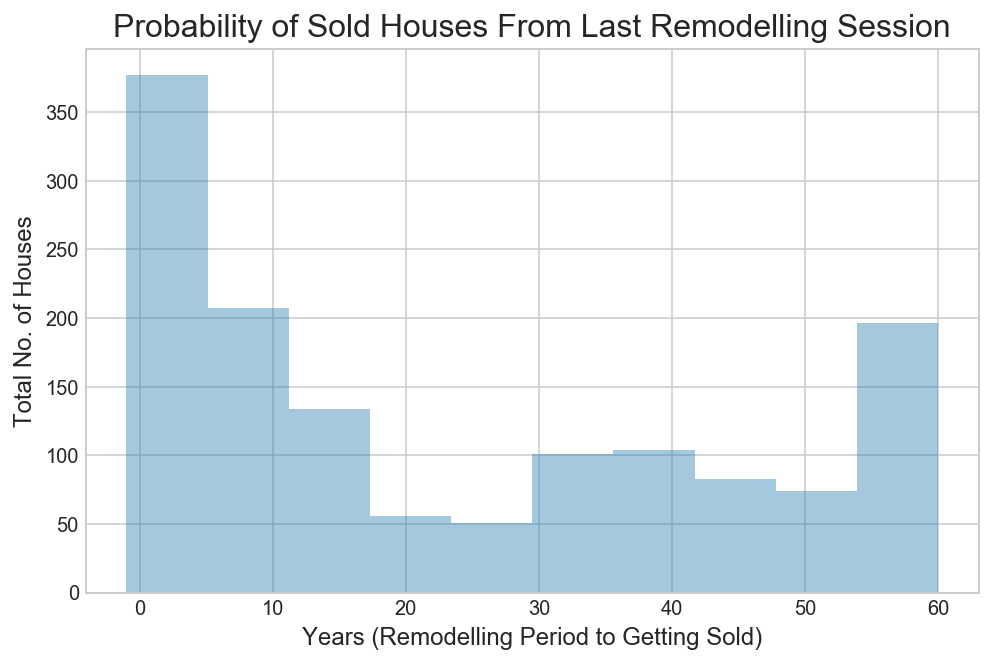

In [31]:
plt.figure (figsize = (8,5))
sns.distplot(fixed_char1['SoldDur'], bins = 10, kde = False)
plt.ylabel('Total No. of Houses', fontsize = 12)
plt.xlabel('Years (Remodelling Period to Getting Sold)', fontsize = 12)
plt.title('Probability of Sold Houses From Last Remodelling Session', fontsize = 16);

In [32]:
fixed_char1.drop(['YearBuilt', 'YearRemodAdd', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'GarageYrBlt'], axis=1, inplace=True)

In [33]:
fixed_char1.head()

,Id,MSZoning,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,OverallQual,Fence,MiscFeature,Alley,Garage&Sold,TotalPorchSF,TotalBaths,TotalRms,RemodelDur,SoldDur
0,1,RL,8450,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,...,7,NaN,NaN,NaN,5.0,61,4,12,0,5
1,2,RL,9600,Pave,Reg,Lvl,FR2,Gtl,Veenker,Feedr,...,6,NaN,NaN,NaN,31.0,0,3,9,0,31
2,3,RL,11250,Pave,IR1,Lvl,Inside,Gtl,CollgCr,Norm,...,7,NaN,NaN,NaN,7.0,42,4,10,1,6
3,4,RL,9550,Pave,IR1,Lvl,Corner,Gtl,Crawfor,Norm,...,7,NaN,NaN,NaN,8.0,307,2,9,55,36
4,5,RL,14260,Pave,IR1,Lvl,FR2,Gtl,NoRidge,Norm,...,8,NaN,NaN,NaN,8.0,84,4,13,0,8


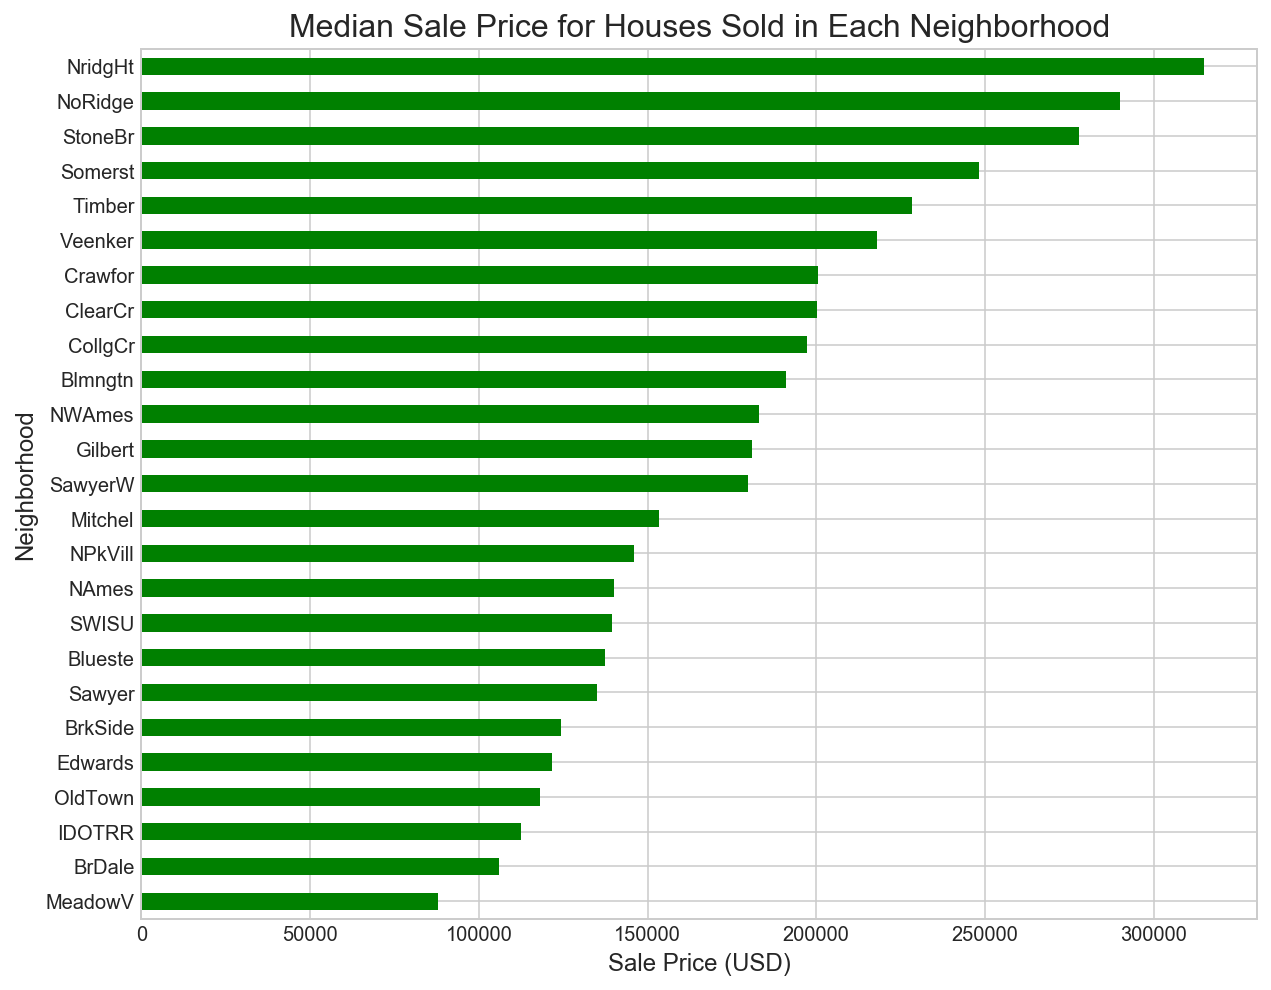

In [34]:
chart = fixed_char1[['SalePrice', 'Neighborhood']].groupby(['Neighborhood']).median()
chart['SalePrice'].sort_values().plot(kind  = 'barh', color = 'g', figsize= (10,8))
plt.title('Median Sale Price for Houses Sold in Each Neighborhood', fontsize = 16)
plt.xlabel ('Sale Price (USD)', fontsize = 12)
plt.ylabel ('Neighborhood', fontsize = 12)
plt.show;

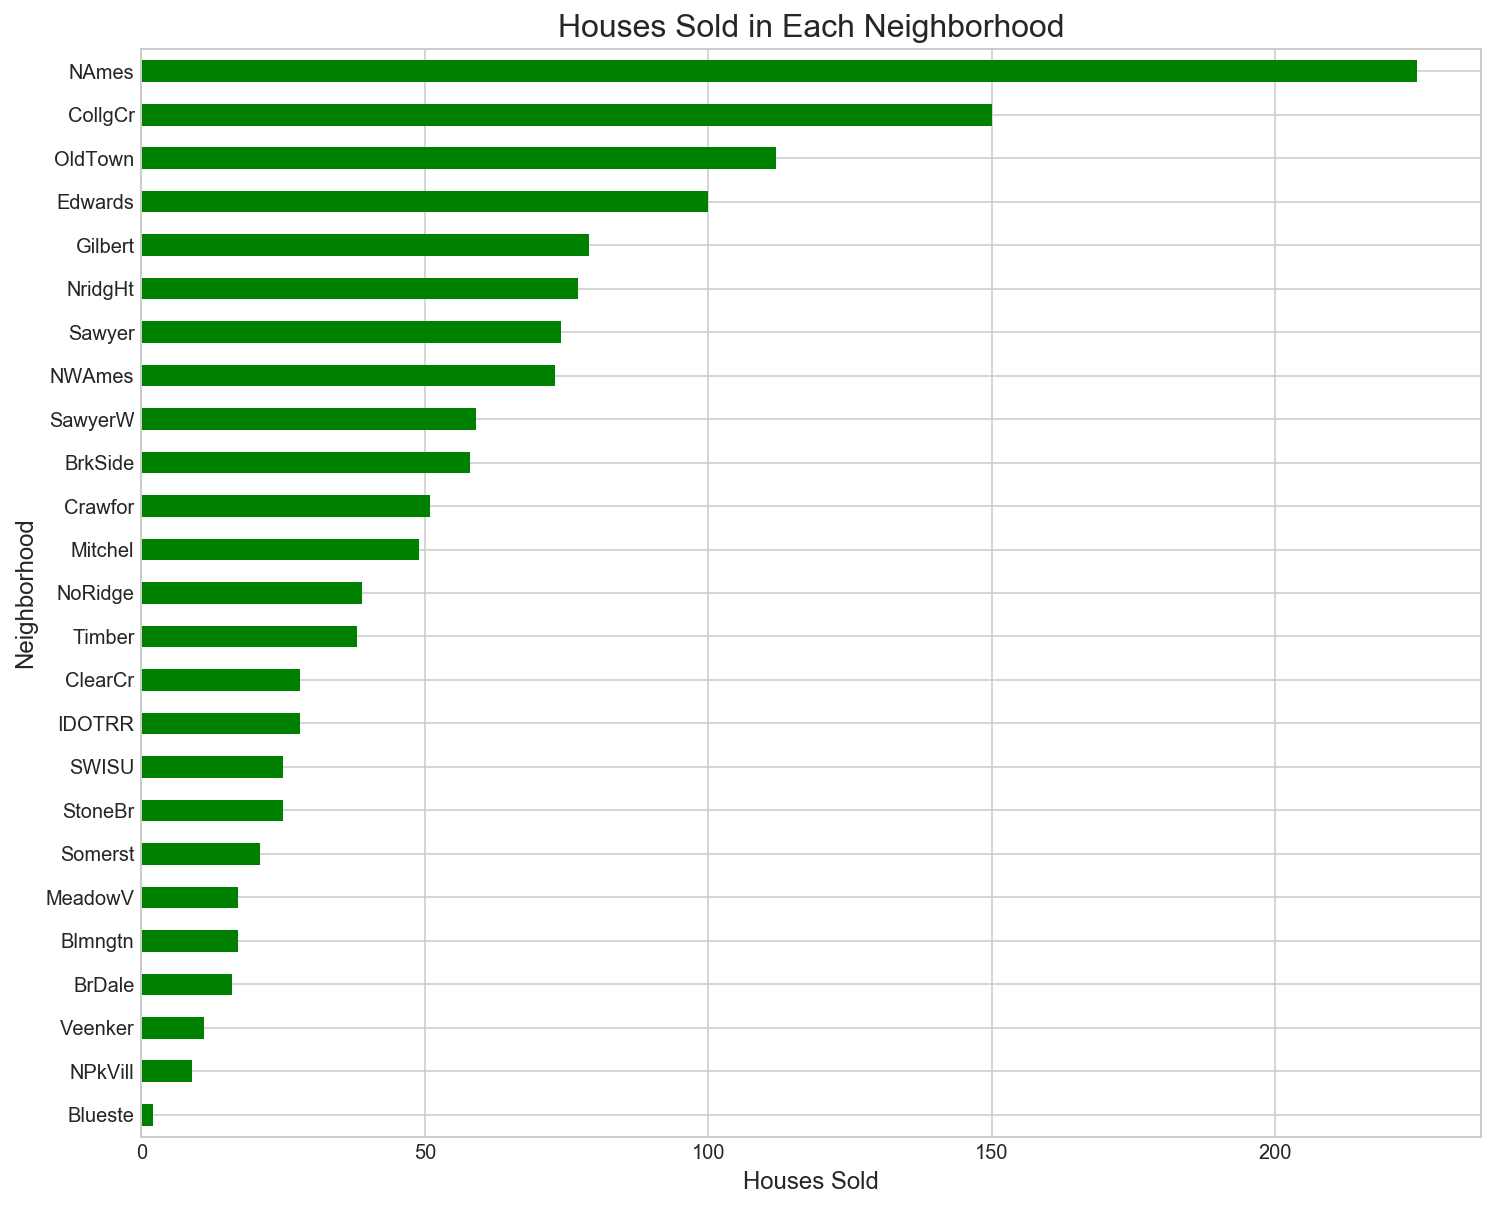

In [35]:
fixed_char1['Neighborhood'].value_counts().sort_values().plot(kind = 'barh', color = 'g', figsize = (12, 10))
plt.title('Houses Sold in Each Neighborhood', fontsize = 16)
plt.xlabel ('Houses Sold', fontsize = 12)
plt.ylabel ('Neighborhood', fontsize = 12)
plt.show;

In [36]:
fixed_char1.columns

Index(['Id', 'MSZoning', 'LotArea', 'Street', 'LotShape', 'LandContour',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'Foundation', 'BsmtExposure', 'TotalBsmtSF',
       'Electrical', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType', 'GarageCars',
       'GarageArea', 'PavedDrive', 'WoodDeckSF', 'YrSold', 'SaleType',
       'SaleCondition', 'SalePrice', 'OverallQual', 'Fence', 'MiscFeature',
       'Alley', 'Garage&Sold', 'TotalPorchSF', 'TotalBaths', 'TotalRms',
       'RemodelDur', 'SoldDur'],
      dtype='object')

In [37]:
fixed_char1.corr()

,Id,LotArea,TotalBsmtSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,YrSold,SalePrice,OverallQual,Garage&Sold,TotalPorchSF,TotalBaths,TotalRms,RemodelDur,SoldDur
Id,1.000000,-0.034147,-0.014625,0.013722,0.044503,0.007025,0.033793,-0.016864,0.011914,0.016364,-0.031291,0.002049,-0.025335,-0.034450,0.003249,-0.005311,0.000280,0.024733,0.002403,0.019847
LotArea,-0.034147,1.000000,0.256215,0.264767,0.109616,-0.020760,0.180184,0.266493,0.161031,0.185522,0.164295,-0.014252,0.273334,0.118392,0.008207,0.076645,0.201695,0.214497,-0.014013,-0.031104
TotalBsmtSF,-0.014625,0.256215,1.000000,0.446592,0.037650,-0.073676,0.275217,0.327494,0.441048,0.501716,0.222679,-0.011746,0.612963,0.547168,-0.331885,0.160820,0.350066,0.344956,-0.247101,-0.302549
GrLivArea,0.013722,0.264767,0.446592,1.000000,0.517803,0.101468,0.832802,0.455840,0.468030,0.472662,0.238350,-0.035342,0.692970,0.592848,-0.229388,0.290022,0.619804,0.862467,0.001697,-0.289484
BedroomAbvGr,0.044503,0.109616,0.037650,0.517803,1.000000,0.196357,0.672171,0.091533,0.086679,0.062820,0.030418,-0.037239,0.155231,0.098528,0.044726,0.108961,0.274115,0.602792,0.047309,0.035877
KitchenAbvGr,0.007025,-0.020760,-0.073676,0.101468,0.196357,1.000000,0.259069,-0.133766,-0.048617,-0.061712,-0.093371,0.035415,-0.138769,-0.185952,0.093344,-0.056005,0.013246,0.194197,0.077469,0.151940
TotRmsAbvGrd,0.033793,0.180184,0.275217,0.832802,0.672171,0.259069,1.000000,0.313772,0.366537,0.336809,0.148898,-0.041542,0.536054,0.436631,-0.161464,0.191401,0.497287,0.933711,0.038578,-0.206840
Fireplaces,-0.016864,0.266493,0.327494,0.455840,0.091533,-0.133766,0.313772,1.000000,0.305902,0.277431,0.186810,-0.014627,0.468941,0.409582,-0.065090,0.205624,0.352394,0.374004,-0.095844,-0.125517
GarageCars,0.011914,0.161031,0.441048,0.468030,0.086679,-0.048617,0.366537,0.305902,1.000000,0.884730,0.229730,-0.038660,0.649515,0.596179,-0.480966,0.095244,0.462593,0.457919,-0.299562,-0.414757
GarageArea,0.016364,0.185522,0.501716,0.472662,0.062820,-0.061712,0.336809,0.277431,0.884730,1.000000,0.229665,-0.025687,0.637043,0.563742,-0.473299,0.131488,0.425888,0.421115,-0.269894,-0.367935


### <font color = blue>Modelling Section</font>
 
#### <font color = blue> - Linear Regression</font>

In [38]:
data = pd.get_dummies(fixed_char1,dummy_na = True, drop_first = True)
data.head()

,Id,LotArea,TotalBsmtSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,...,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_nan,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_nan,Alley_Pave,Alley_nan
0,1,8450,856,1710,3,1,8,0,2,548,...,0,0,0,1,0,0,0,1,0,1
1,2,9600,1262,1262,3,1,6,1,2,460,...,0,0,0,1,0,0,0,1,0,1
2,3,11250,920,1786,3,1,6,1,2,608,...,0,0,0,1,0,0,0,1,0,1
3,4,9550,756,1717,3,1,7,1,3,642,...,0,0,0,1,0,0,0,1,0,1
4,5,14260,1145,2198,4,1,9,1,3,836,...,0,0,0,1,0,0,0,1,0,1


In [39]:
Test = data[data['YrSold'] == 2010]
Test.drop(['YrSold', 'Id'], axis = 1, inplace = True)
Train = data[data['YrSold'] != 2010]
Train.drop(['YrSold', 'Id'], axis = 1, inplace = True)

C:\Users\syami\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\syami\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [40]:
X_test = Test.loc[: , Test.columns != 'SalePrice']
y_test = Test['SalePrice']

In [41]:
np.mean (Train['SalePrice'])
# baseline

179512.8203445447

In [42]:
X_train = Train.loc[: , Train.columns != 'SalePrice']
y_train = Train['SalePrice']

from sklearn.preprocessing import StandardScaler
data = X_train.values
scaler = StandardScaler()
# print (scaler.fit(data))

scaled = scaler.fit_transform (data)

In [43]:
Xs = scaled
y = y_train

lr = LinearRegression()
lr.fit(Xs, y)
lr.score(Xs, y)
# create the RFE model for the svm classifier 
# and select attributes
# score = cross_val_score(lr, Xs, y, cv = 5)
# # print summaries for the selection of attributes
# print('Scores = ', score, 'Mean of scores = ', np.mean(score))

0.8820599312904576

In [44]:
data = X_test.values
scaler = StandardScaler()
# print (scaler.fit(data))

scaled_test = scaler.fit_transform (data)

In [45]:
Xst = scaled_test
y_test = Test['SalePrice']
model = lr.fit(Xs, y)
Train_score = model.score(Xs, y)
Test_score = model.score(Xst, y_test)

print ('Training Score = ', Train_score)
print ('Test Score = ', Test_score)

Training Score =  0.8820599312904576
Test Score =  -3.719891462532145e+20


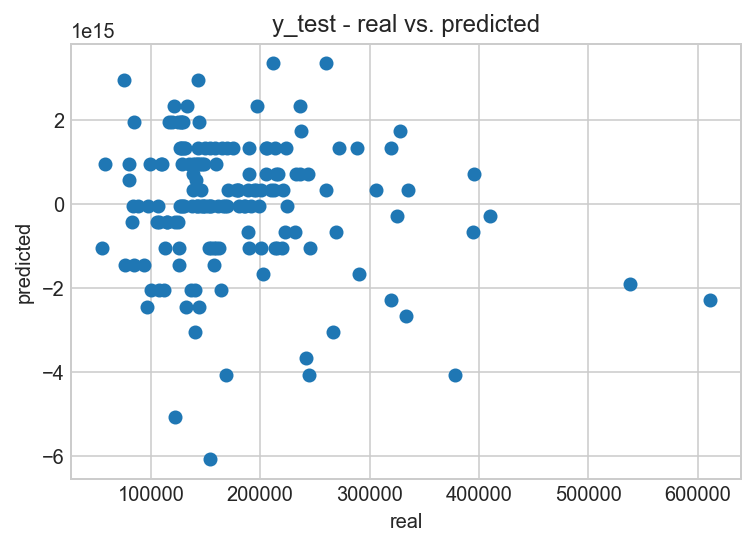

In [46]:
yhat = model.predict(Xst)
plt.scatter(y_test, yhat)
plt.title('y_test - real vs. predicted')
plt.xlabel('real')
plt.ylabel('predicted')
plt.show()

In [47]:
coeff = pd.DataFrame(X_train.columns)
coeff['Coefficient Estimate'] = pd.Series(lr.coef_)
coeff.sort_values(by = 'Coefficient Estimate', ascending = False, kind = 'quicksort').head(10)

,0,Coefficient Estimate
5,TotRmsAbvGrd,2.321934e+16
13,TotalBaths,1.338184e+16
19,MSZoning_nan,1.021840e+16
21,Street_nan,3.456078e+15
34,LotConfig_nan,1.953468e+15
25,LotShape_nan,3.843097e+14
79,Condition2_nan,1.501437e+11
84,BldgType_nan,7.580732e+09
92,HouseStyle_nan,1.625578e+08
2,GrLivArea,2.097291e+04


#### <font color = blue>Cross-Validated Lin Reg</font>

In [48]:
linreg = LinearRegression()
cv_linreg = cross_val_score(linreg, Xs, y, cv = 10)
np.mean(cv_linreg)

-3.0336363309824e+21

In [49]:
linreg.fit(Xs,y)
linreg.score(Xst, y_test)

-3.719891462532145e+20

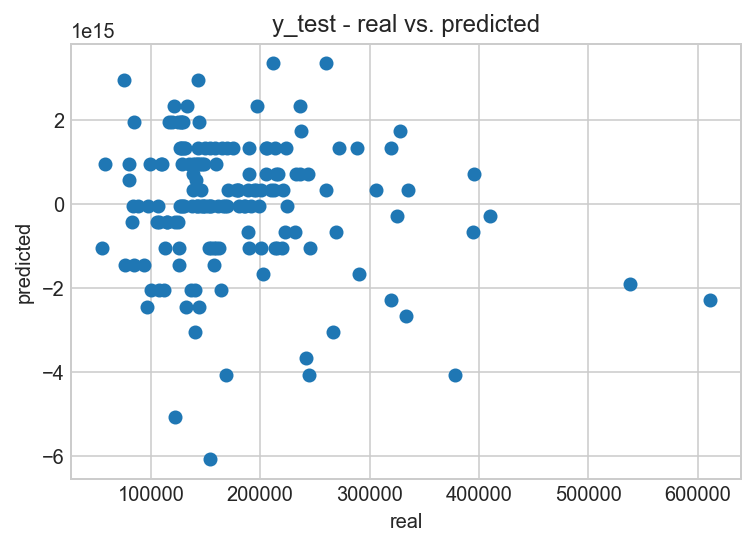

In [50]:
yhat = linreg.predict(Xst)
plt.scatter(y_test, yhat)
plt.title('y_test - real vs. predicted')
plt.xlabel('real')
plt.ylabel('predicted')
plt.show()

#### <font color = blue> - Regularization: Ridge</font>

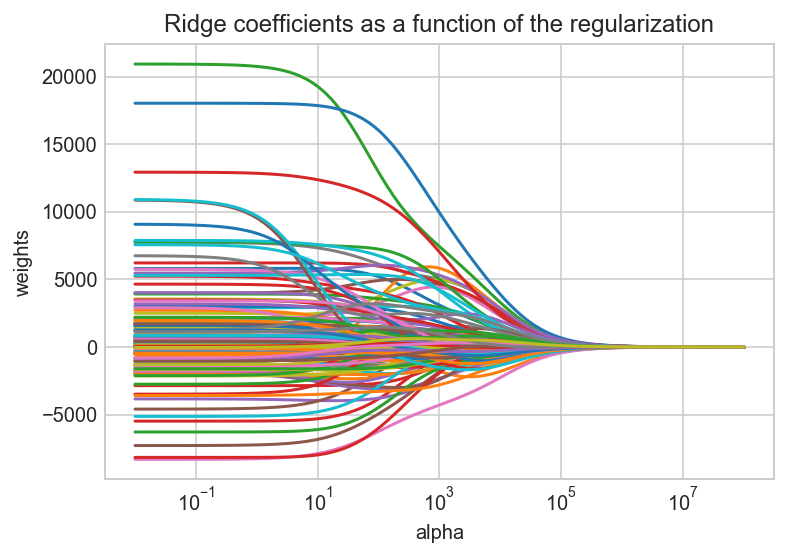

In [51]:
n_alphas = 100
alphas = np.logspace(8, -2, n_alphas)

coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False)
    ridge.fit(Xs, y)
    coefs.append(ridge.coef_)

# #############################################################################
# Display results

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [52]:
ridge = Ridge(alpha = 10**2)
model = ridge.fit(Xs, y)
Ridge_train = model.score(Xs, y)
Ridge_test = model.score(Xst, y_test)

print ('Training score for ridge = ', Ridge_train)
print ('Test score for ridge = ', Ridge_test)

Training score for ridge =  0.8781231861526808
Test score for ridge =  0.8866855894971806


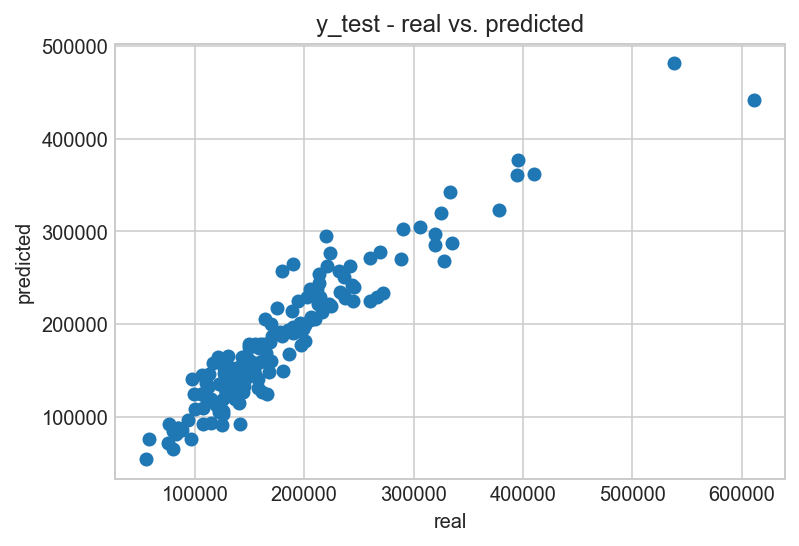

In [53]:
y_pred = model.predict(Xst)
plt.scatter(y_test, y_pred)
plt.title('y_test - real vs. predicted')
plt.xlabel('real')
plt.ylabel('predicted')
plt.show()

In [54]:
mse = np.mean((y_pred - y_test)**2)
mse

742503507.8152541

In [55]:
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
rmse

27248.917553092895

#### <font color = blue> RidgeCV</font>

In [56]:
ridge = RidgeCV (alphas = [0.1, 1.0, 5.0, 10.0], cv = 5)
ridge.fit(Xs, y)
ridge.alpha_

10.0

In [57]:
ridge.score(Xst, y_test)

0.8869092173278057

#### <font color = blue> - Regularization: Lasso</font>

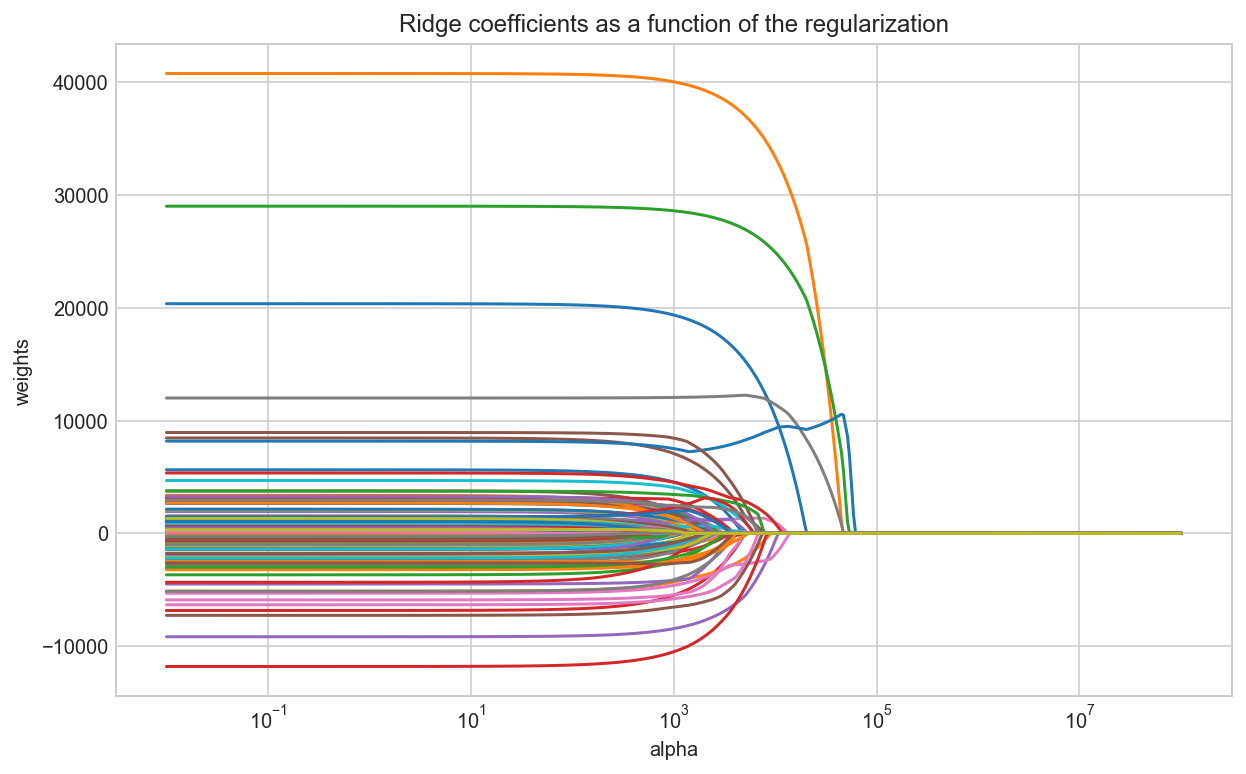

In [58]:
n_alphas = 500
alphas = np.logspace(8, -2, n_alphas)

coefs = []
for a in alphas:
    lasso = Lasso(alpha=a, fit_intercept=False, tol = 10)
    lasso.fit(Xs, y)
    coefs.append(lasso.coef_)
    
plt.figure(figsize = (10,6))
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [59]:
lasso = Lasso (alpha = 10**2)
lasso.fit(Xs, y)

print ('Lasso Training Score = ', lasso.score(Xs, y))
print ('Lasso Test Score = ', lasso.score(Xst, y_test))

Lasso Training Score =  0.8809875024390519
Lasso Test Score =  0.887379768765023


In [60]:
yTrain_pred = lasso.predict(Xs)
residual_train = y - yTrain_pred

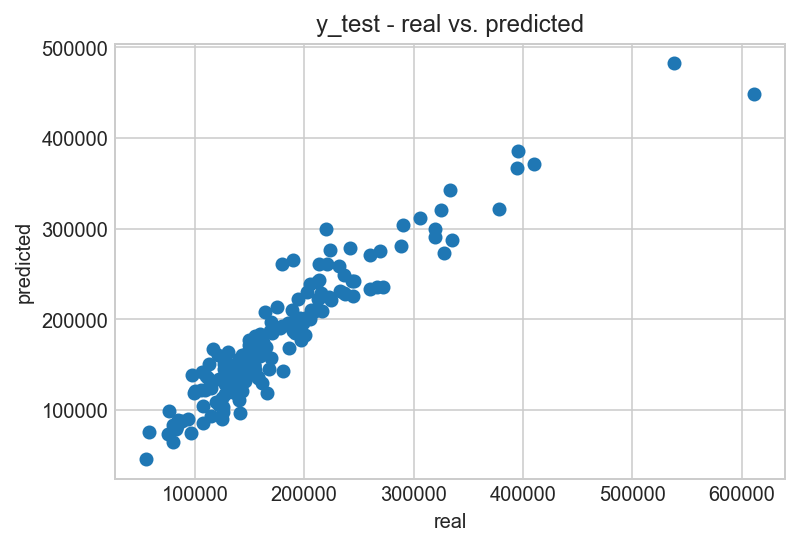

In [61]:
y_pred = lasso.predict(Xst)
plt.scatter(y_test, y_pred)
plt.title('y_test - real vs. predicted')
plt.xlabel('real')
plt.ylabel('predicted')
plt.show()

In [62]:
residual_test = y_test - y_pred

In [63]:
mse = np.mean((y_pred - y_test)**2)
mse

737954831.7983329

In [64]:
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
rmse

27165.32406945172

In [65]:
np.sum(lasso.coef_ != 0)

113

In [66]:
lasso_coefs = pd.DataFrame({'variable':X_train.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(20)

,abs_coef,coef,variable
2,19594.673284,19594.673284,GrLivArea
10,18192.805603,18192.805603,OverallQual
53,12936.240612,12936.240612,Neighborhood_NridgHt
14,10671.416046,10671.416046,TotalRms
52,7927.703945,7927.703945,Neighborhood_NoRidge
59,7735.949507,7735.949507,Neighborhood_StoneBr
7,7565.730864,7565.730864,GarageCars
16,7558.862107,-7558.862107,SoldDur
83,7541.639143,-7541.639143,BldgType_TwnhsE
129,6852.320708,6852.320708,SaleType_New


#### <font color = blue>LassoCV</font>

In [67]:
lasso = LassoCV (cv = 4)
lasso.fit(Xs, y)
lasso.alpha_

401.0126421408587

In [68]:
lasso_reg = Lasso(alpha=lasso.alpha_)
lasso_scores = cross_val_score(lasso_reg, Xs, y, cv=4)

print(lasso_scores)
print(np.mean(lasso_scores))

[0.87697475 0.84329076 0.80759971 0.70692705]
0.8086980670254469


In [69]:
lasso_reg.fit(Xs, y)
lasso_reg.score(Xst, y_test)

0.8828414110817818

### <font color = blue>Conclusion</font>
#### <font color = blue> - The Lasso model, without CV, produced a training score of 0.881 and a test score of 0.887 as compared to the Linear Regression and Regularization through Ridge models. </font>
#### <font color = blue> - From this model, it can be deduced that the fixed characteristics of a property could predict almost 89% of its sale price.</font>

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [70]:
reno_char = house1[['OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', \
                    'MasVnrType','ExterQual', 'ExterCond', 'BsmtQual','BsmtCond', 'BsmtFinType1',\
                    'BsmtFinType2', 'HeatingQC','KitchenQual','Fireplaces',\
                    'FireplaceQu','GarageQual','GarageCond', 'PoolQC', 'SalePrice', 'YrSold']]

In [71]:
reno_char.corr()

,OverallCond,Fireplaces,SalePrice,YrSold
OverallCond,1.000000,-0.038677,-0.083386,0.048443
Fireplaces,-0.038677,1.000000,0.468941,-0.014627
SalePrice,-0.083386,0.468941,1.000000,-0.027036
YrSold,0.048443,-0.014627,-0.027036,1.000000


In [72]:
# Replacing the numbers in OverallCond to categorical before getting dummies.
def func (x):
    if x == 10:
        return 'Very Excellent'
    if x == 9:
        return 'Excellent'
    if x == 8:
        return 'Very Good'
    if x == 7:
        return 'Good'
    if x == 6:
        return 'Above Average'
    if x == 5:
        return 'Average'
    if x == 4:
        return 'Below Average'
    if x == 3:
        return 'Fair'
    if x == 2:
        return 'Poor'
    else:
        return 'Very Poor'

In [73]:
reno_char['NewCond'] = reno_char['OverallCond'].apply(func)
reno_char.head()

C:\Users\syami\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,BsmtQual,BsmtCond,...,HeatingQC,KitchenQual,Fireplaces,FireplaceQu,GarageQual,GarageCond,PoolQC,SalePrice,YrSold,NewCond
0,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,Gd,TA,...,Ex,Gd,0,NaN,TA,TA,NaN,208500,2008,Average
1,8,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,Gd,TA,...,Ex,TA,1,TA,TA,TA,NaN,181500,2007,Very Good
2,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,Gd,TA,...,Ex,Gd,1,TA,TA,TA,NaN,223500,2008,Average
3,5,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,TA,Gd,...,Gd,Gd,1,Gd,TA,TA,NaN,140000,2006,Average
4,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,Gd,TA,...,Ex,Gd,1,TA,TA,TA,NaN,250000,2008,Average


In [74]:
reno_char.drop(['OverallCond'], axis=1, inplace=True)

C:\Users\syami\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [75]:
reno_char.head()

,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinType1,...,HeatingQC,KitchenQual,Fireplaces,FireplaceQu,GarageQual,GarageCond,PoolQC,SalePrice,YrSold,NewCond
0,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,Gd,TA,GLQ,...,Ex,Gd,0,NaN,TA,TA,NaN,208500,2008,Average
1,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,Gd,TA,ALQ,...,Ex,TA,1,TA,TA,TA,NaN,181500,2007,Very Good
2,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,Gd,TA,GLQ,...,Ex,Gd,1,TA,TA,TA,NaN,223500,2008,Average
3,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,TA,Gd,ALQ,...,Gd,Gd,1,Gd,TA,TA,NaN,140000,2006,Average
4,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,Gd,TA,GLQ,...,Ex,Gd,1,TA,TA,TA,NaN,250000,2008,Average


#### <font color = blue>Just some visualizations to get an idea</font>

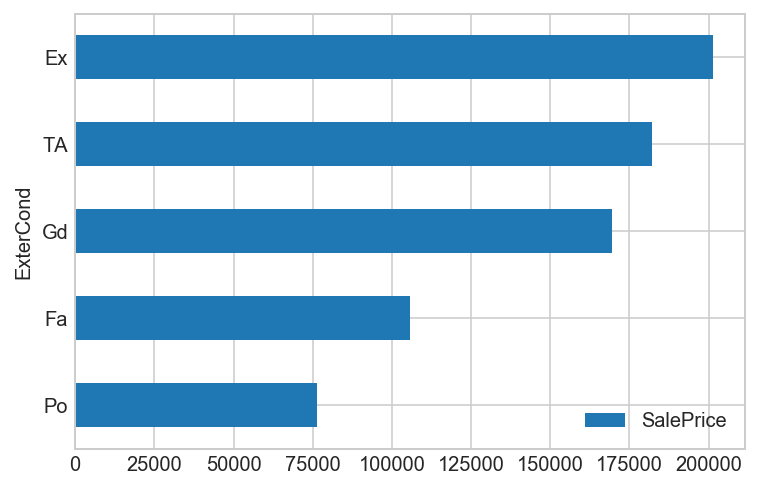

In [76]:
reno_char[['SalePrice','ExterCond']].groupby(['ExterCond']).mean().sort_values(by = ['SalePrice']).plot(kind = 'barh')

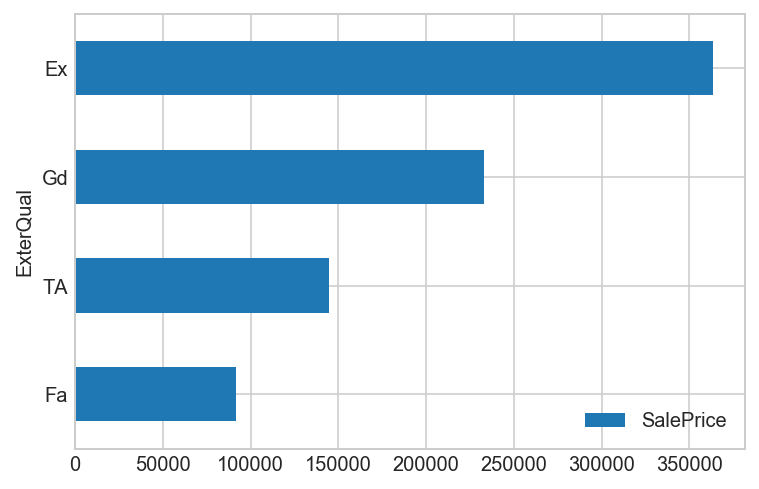

In [77]:
reno_char[['SalePrice','ExterQual']].groupby(['ExterQual']).mean().sort_values(by = ['SalePrice']).plot(kind = 'barh')

In [78]:
reno_char.head()

,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinType1,...,HeatingQC,KitchenQual,Fireplaces,FireplaceQu,GarageQual,GarageCond,PoolQC,SalePrice,YrSold,NewCond
0,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,Gd,TA,GLQ,...,Ex,Gd,0,NaN,TA,TA,NaN,208500,2008,Average
1,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,Gd,TA,ALQ,...,Ex,TA,1,TA,TA,TA,NaN,181500,2007,Very Good
2,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,Gd,TA,GLQ,...,Ex,Gd,1,TA,TA,TA,NaN,223500,2008,Average
3,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,TA,Gd,ALQ,...,Gd,Gd,1,Gd,TA,TA,NaN,140000,2006,Average
4,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,Gd,TA,GLQ,...,Ex,Gd,1,TA,TA,TA,NaN,250000,2008,Average


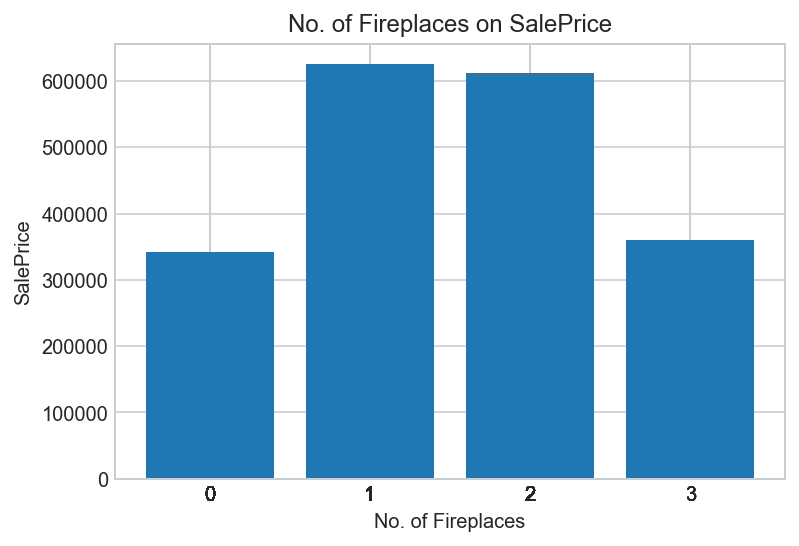

In [79]:
plt.bar(reno_char['Fireplaces'], reno_char['SalePrice'])
plt.xticks(reno_char['Fireplaces'])
plt.title('No. of Fireplaces on SalePrice')
plt.xlabel('No. of Fireplaces')
plt.ylabel('SalePrice')
plt.show();

<Container object of 1383 artists>

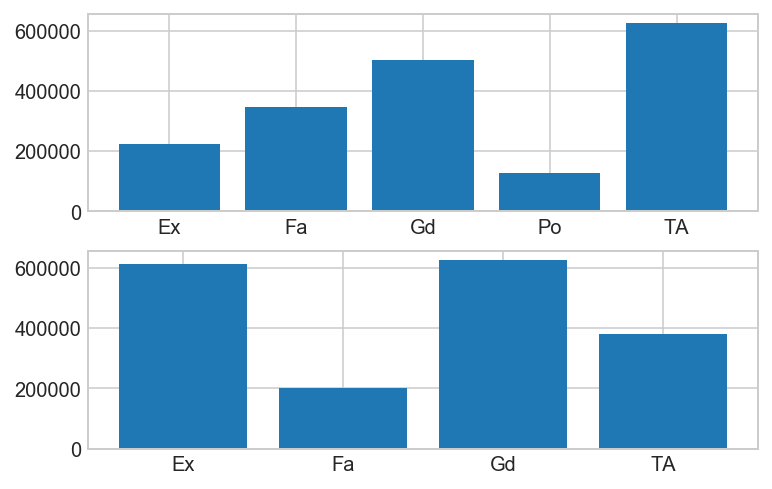

In [80]:
fig1, (ax1, ax2) = plt.subplots(2,1) # two rows, one column

ax1.bar(reno_char ['ExterCond'].sort_values(), reno_char ['SalePrice'])

ax2.bar(reno_char ['ExterQual'], reno_char ['SalePrice'])

### <font color = blue>Modelling Section.</font>
 
#### <font color = blue> - Linear Regression</font>

In [81]:
data1 = pd.get_dummies(reno_char, dummy_na = True, drop_first = True)
data1.head()

,Fireplaces,SalePrice,YrSold,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofStyle_nan,RoofMatl_CompShg,...,PoolQC_nan,NewCond_Average,NewCond_Below Average,NewCond_Excellent,NewCond_Fair,NewCond_Good,NewCond_Poor,NewCond_Very Good,NewCond_Very Poor,NewCond_nan
0,0,208500,2008,1,0,0,0,0,0,1,...,1,1,0,0,0,0,0,0,0,0
1,1,181500,2007,1,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
2,1,223500,2008,1,0,0,0,0,0,1,...,1,1,0,0,0,0,0,0,0,0
3,1,140000,2006,1,0,0,0,0,0,1,...,1,1,0,0,0,0,0,0,0,0
4,1,250000,2008,1,0,0,0,0,0,1,...,1,1,0,0,0,0,0,0,0,0


In [82]:
Test = data1[data1['YrSold'] == 2010]
Test.drop(['YrSold', 'SalePrice'], axis = 1, inplace = True)
Train = data1[data1['YrSold'] != 2010]
Train.drop(['YrSold', 'SalePrice'], axis = 1, inplace = True)

C:\Users\syami\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\syami\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


#### <font color = blue> - Standardization.</font>

In [83]:
# I used the residuals from my previous Lasso model which gave me quite a 
# good score for both training and testing.

X_train = Train
y_train = residual_train

from sklearn.preprocessing import StandardScaler
reno_Xt = X_train.values
scaler = StandardScaler()
# print (scaler.fit(data))

scaled = scaler.fit_transform (reno_Xt)

C:\Users\syami\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [84]:
X_test = Test
y_test = residual_test

from sklearn.preprocessing import StandardScaler
reno_Xtt = X_test.values
scaler = StandardScaler()
# print (scaler.fit(data))

scaled_test = scaler.fit_transform (reno_Xtt)

C:\Users\syami\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [85]:
Xs = scaled
yt = y_train

Xst = scaled_test
ytt = y_test

In [86]:
np.mean(yt)

-2.1523464443597566e-11

In [87]:
lr = LinearRegression()
model = lr.fit(Xs, yt)
Train_score = model.score(Xs, yt)
Test_score = model.score(Xst, ytt)

print ('Training Score = ', Train_score)
print ('Test Score = ', Test_score)

Training Score =  0.2837758280270748
Test Score =  -1.1357816374878883e+24


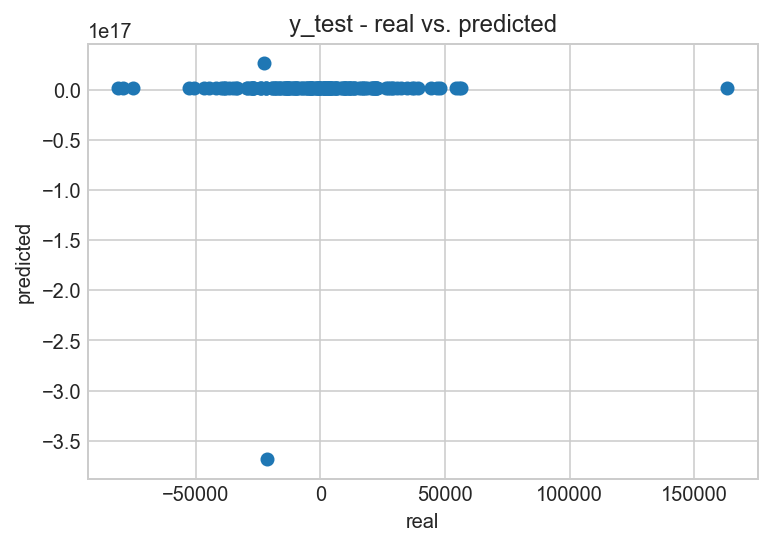

In [88]:
y_pred = model.predict(Xst)
plt.scatter(ytt, y_pred)
plt.title('y_test - real vs. predicted')
plt.xlabel('real')
plt.ylabel('predicted')
plt.show()

In [89]:
coeff = pd.DataFrame(X_train.columns)
coeff['Coefficient Estimate'] = pd.Series(lr.coef_)
coeff.sort_values(by = 'Coefficient Estimate', ascending = False, kind = 'quicksort').head(40)

,0,Coefficient Estimate
6,RoofStyle_nan,6.596770e+16
66,BsmtCond_nan,4.017915e+16
72,BsmtFinType1_nan,3.997251e+16
33,Exterior2nd_CBlock,2.804302e+16
102,GarageCond_nan,2.564555e+16
56,ExterCond_Po,1.874524e+15
53,ExterQual_nan,4.002679e+14
7,RoofMatl_CompShg,5.436420e+04
11,RoofMatl_Tar&Grv,3.668400e+04
13,RoofMatl_WdShngl,2.629000e+04


In [90]:
rmse = np.sqrt(np.mean((y_pred - ytt)**2))
rmse

2.889470852373789e+16

#### <font color = blue> - Regularization: Ridge</font>

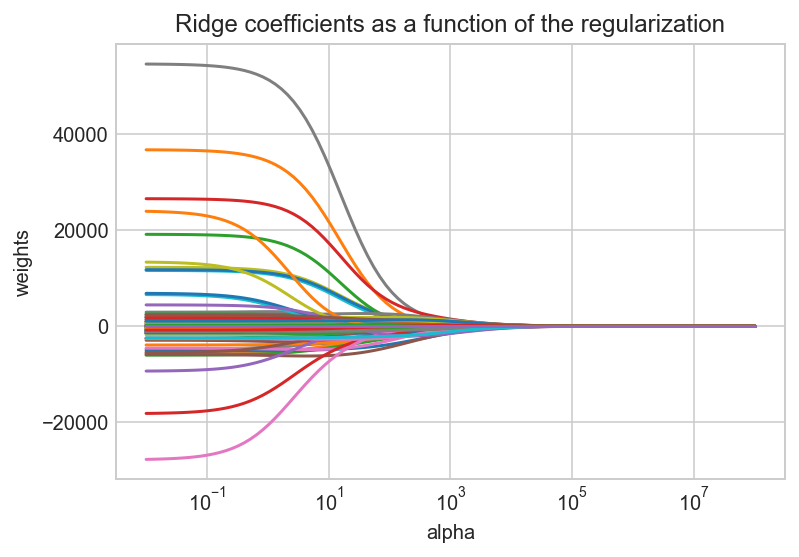

In [91]:
n_alphas = 100
alphas = np.logspace(8, -2, n_alphas)

coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False)
    ridge.fit(Xs, yt)
    coefs.append(ridge.coef_)

# #############################################################################
# Display results

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [92]:
ridge = Ridge(alpha = 10**2.5)
model = ridge.fit(Xs, yt)
Ridge_train = model.score(Xs, yt)
Ridge_test = model.score(Xst, ytt)

print ('Training score for ridge = ', Ridge_train)
print ('Test score for ridge = ', Ridge_test)

Training score for ridge =  0.16066620002347132
Test score for ridge =  0.09071528323252609


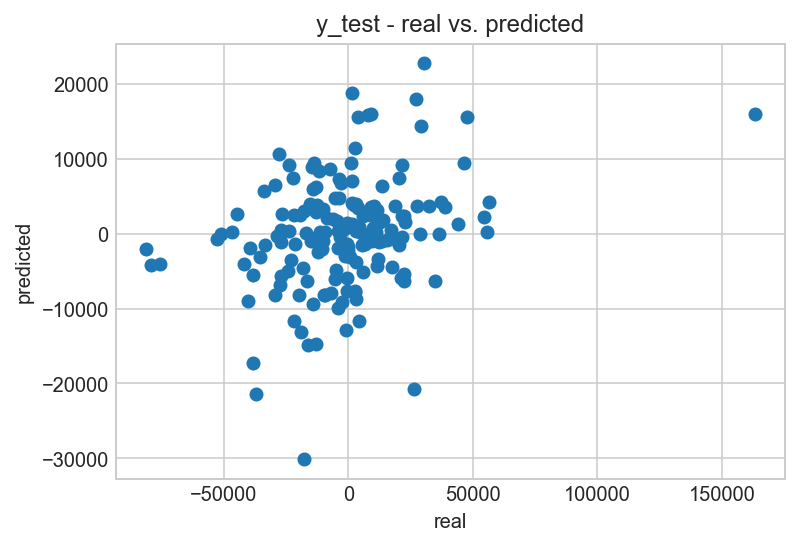

In [93]:
y_pred = model.predict(Xst)
plt.scatter(ytt, y_pred)
plt.title('y_test - real vs. predicted')
plt.xlabel('real')
plt.ylabel('predicted')
plt.show()

In [94]:
rmse = np.sqrt(np.mean((y_pred - ytt)**2))
rmse

25853.589098838533

#### <font color = blue> - Regularization: Lasso</font>

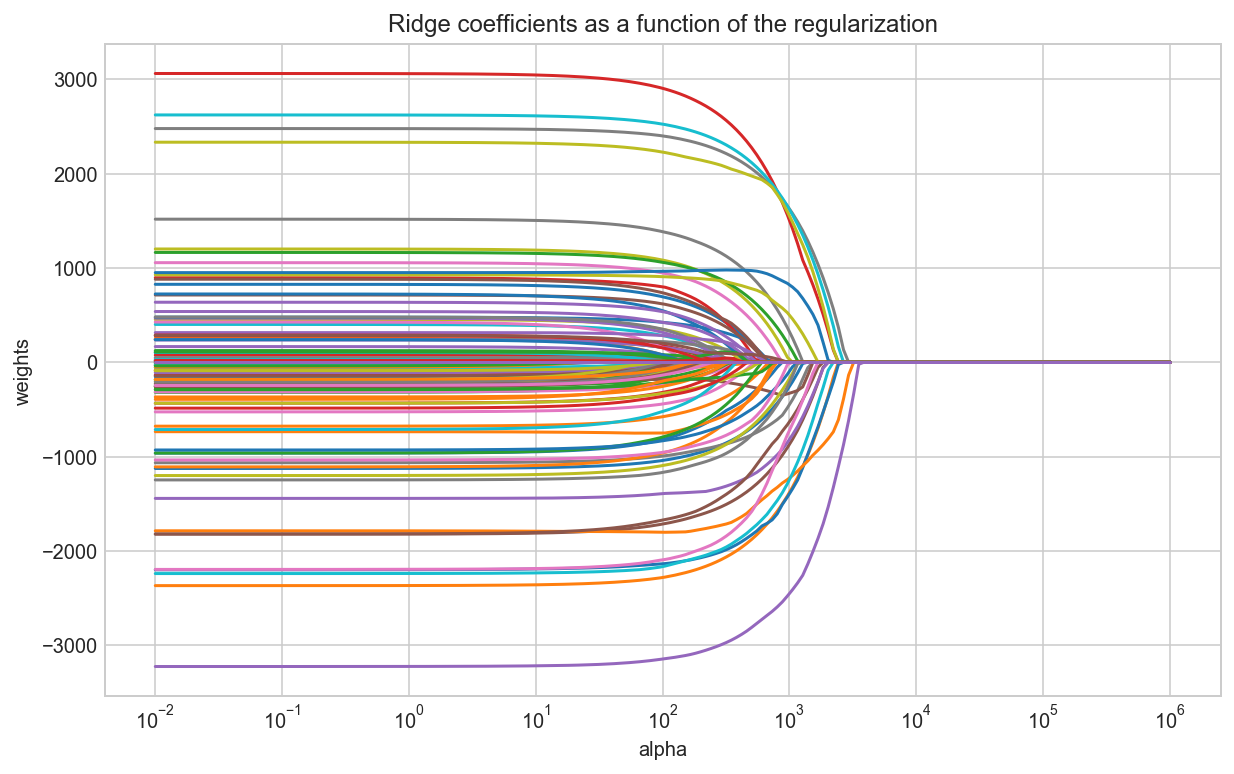

In [95]:
n_alphas = 200
alphas = np.logspace(6, -2, n_alphas)

coefs = []
for a in alphas:
    lasso = Lasso(alpha=a, fit_intercept=False, tol = 50)
    lasso.fit(Xs, yt)
    coefs.append(lasso.coef_)
    
plt.figure(figsize = (10,6))
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [96]:
lasso = Lasso(alpha = 10**3)
model = lasso.fit(Xs, yt)
Lasso_train = model.score(Xs, yt)
Lasso_test = model.score(Xst, ytt)

print ('Training score for lasso = ', Lasso_train)
print ('Test score for lasso = ', Lasso_test)

Training score for lasso =  0.10055173140021056
Test score for lasso =  0.04992906625147886


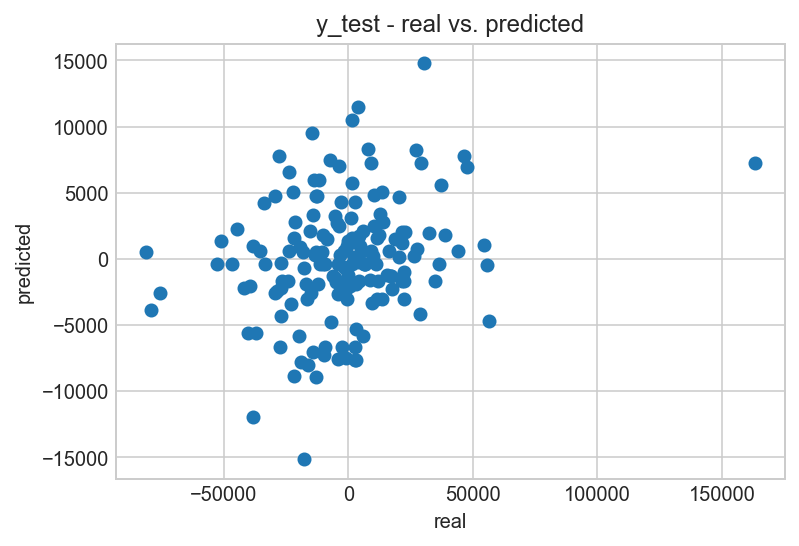

In [97]:
y_pred = model.predict(Xst)
plt.scatter(ytt, y_pred)
plt.title('y_test - real vs. predicted')
plt.xlabel('real')
plt.ylabel('predicted')
plt.show()

In [98]:
rmse = np.sqrt(np.mean((y_pred - ytt)**2))
rmse

26427.06373692441

In [99]:
np.sum(model.coef_ != 0)

23

In [100]:
lasso_coefs = pd.DataFrame({'variable':X_train.columns,
                            'coef':model.coef_,
                            'abs_coef':np.abs(model.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(20)

,abs_coef,coef,variable
104,2534.753899,-2534.753899,PoolQC_Gd
60,1761.942840,-1761.942840,BsmtQual_Gd
68,1646.904281,1646.904281,BsmtFinType1_GLQ
17,1542.199206,1542.199206,Exterior1st_BrkFace
13,1387.896688,1387.896688,RoofMatl_WdShngl
71,1181.185512,-1181.185512,BsmtFinType1_Unf
109,1162.988574,-1162.988574,NewCond_Fair
110,1064.082156,1064.082156,NewCond_Good
44,995.764245,-995.764245,Exterior2nd_Wd Shng
19,948.585366,948.585366,Exterior1st_CemntBd


### <font color = blue>Conclusion</font>
#### <font color = blue> - The ridge model produced a training score of 0.160 and a test score of 0.091. </font>
#### <font color = blue> - Although the test performed slightly worse than the training, this model is better as compared to using Linear Regression and also regularization through Lasso. Through this model, I think the effect of the renovate-able features has an impact of about 9% as compared to when utilizing the fixed features of a housing property in Qn 1. Although the renovate-able features only contribute of about 1/10th of a property, it is still wise to consider these as part of the Sale Price of a property.</font>
#### <font color = blue> - I do trust my models. Only am not sure if I'm doing this right.</font>

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [101]:
# A:
# Don't just look at accuracy scores and precision-recall in the confusion matrix,
# if the numbers have no 0 and there's so much imbalance then redo this.
# 